In [11]:
import numpy as np 
import matplotlib.pyplot as plt 
# Custom libs
import GAutils.objects as ob
import GAutils.config as cfg # Sim parameters
import GAutils.proc_est as pr
import GAutils.simulate_snapshot2 as sim2
import GAutils.perf_eval as prfe
import GAutils.PCRLB as pcrlb


Generate Range, doppler data

In [12]:
Nob = 4
Nsens = 4
swidth = 2
snr = 10
seed = np.random.randint(1000, size=1)
# Generate sensors
sx = np.linspace(-swidth/2, swidth/2,Nsens)
sensors = [ob.Sensor(x,0) for x in sx]
scene = pr.init_random_scene(Nob, sensors, cfg.sep_th, seed)

Perform association

In [15]:
inst = 0
cfgp = {'Nsel': [],# Genie info on # targets
                'rd_wt':cfg.rd_wt,
                'static_snapshot': cfg.static_snapshot,
                'sep_th':cfg.sep_th,
                'pmiss':cfg.pmissa[inst],
                'estalgo':cfg.estalgo, 
                'osps':cfg.osps,
                'n_Rc':cfg.n_Rc,
                'n_pfa':cfg.n_pfa,
                # Association
                'rob': 20, #cfg.roba[inst],
                'mode': cfg.mode,
                'hscale':cfg.hscale,
                'incr':cfg.incr,
                'hN': cfg.hN,
                'ag_pfa':cfg.ag_pfa,
                'al_pfa':cfg.al_pfa,
                'Tlen':cfg.Tlen,
                # Gauss Newton
                'gn_steps':cfg.gn_steps,
                'fu_alg':cfg.fu_alg
                }
snapshot_result = sim2.run_snapshot(scene, sensors, snr, cfgp, seed)
ret, det, Nmisst, Nfat, crbt, presentt = snapshot_result['RDpack']

Plot the scene

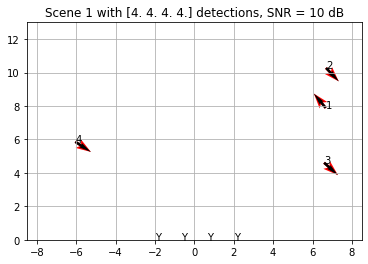

In [19]:
sx=np.linspace(-swidth, swidth, Nsens)
sensorsp = [ob.Sensor(x,0) for x in sx]
phlist = snapshot_result['loc']
fig = plt.figure(15)
plt.clf()
for gr in phlist: 
    if abs(gr.vx)+abs(gr.vy)>0:
        plt.quiver(gr.x, gr.y,gr.vx,gr.vy, color='r', headwidth = 4, headlength=6, headaxislength=5)
    else:
        plt.plot(gr.x, gr.y, 'ro')
pr.plot_scene(plt, scene[:Nob], sensorsp, 15, 'Scene {} with {} detections, SNR = {} dB'.format(1, np.round(np.sum(presentt, axis=1)), round(snr)))
